In [5]:
!git clone https://github.com/N4SIRODDIN3/Automatic-Room-Segmentation-and-Labelling-in-Architectural-Floor-Plan-Images.git ARFP

Cloning into 'ARFP'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 77 (delta 3), reused 63 (delta 0), pack-reused 0
Receiving objects: 100% (77/77), 4.99 MiB | 25.66 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [13]:
import cv2
import numpy as np
import pytesseract
import random
from matplotlib import pyplot as plt
# since colab doesn't support cv2.show, we need to import another version from colab itself
from google.colab.patches import cv2_imshow


In [8]:
!apt install tesseract-ocr # to avoid getting error of path with pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,943 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120876 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [12]:
def extract_room_labels(img):
    # Create mask of same size as image
    mask = np.zeros(img.shape, dtype=np.uint8)

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply adaptive thresholding
    threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Find contours in binary image
    contours, hierarchy = cv2.findContours(
        threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )

    # Draw contours on mask for those within width and height boundaries
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w < 40 and 12 < h < 20:  # Parameters
            cv2.drawContours(mask, [cnt], 0, (255, 255, 255), 1)

    # cv2_imshow("mask", mask)

    # Perform dilation on the contoured objects so words can be identified as one and repeat process as above
    kernel = np.ones((4, 4), np.uint8)  # Variable
    dilation = cv2.dilate(mask, kernel, iterations=1)
    gray_d = cv2.cvtColor(dilation, cv2.COLOR_BGR2GRAY)

    threshold_d = cv2.threshold(gray_d, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    contours_d, hierarchy = cv2.findContours(
        threshold_d, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Create copy to show image once texts are removed
    text_extracted_img = img.copy()
    bounded_text_img = img.copy()

    ROI = []
    coordinates = []

    # Draw rectangle on bounding boxes within width and height boundaries
    for cnt in contours_d:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 10:  # Parameter
            cv2.rectangle(bounded_text_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            roi_c = bounded_text_img[y : y + h, x : x + w]
            coordinates.append((x, y, w, h))
            ROI.append(roi_c)
            text_extracted_img[
                y : y + h, x : x + w
            ] = 255  # Replace the identified text with white color

    # plt.figure()
    # plt.imshow(bounded_text_img)
    cv2_imshow(bounded_text_img)

    # Extract texts from bounding boxes
    room_labels = []
    for i, room in enumerate(ROI):
        text = pytesseract.image_to_string(room, lang="eng", config="--psm 6")  # config
        text = text.replace("\n", " ")
        room_labels.append((text, coordinates[i]))

    return room_labels, text_extracted_img
def fill_wall_gaps(img):
    corners_detacted_img = img.copy()
    gaps_filled_img = img.copy()

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh= cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    thresh = np.float32(thresh)   # Converted to float32 type for Harris Corner function

    # Detect corners here
    dst = cv2.cornerHarris(thresh, 3, 7, 0.07)   # Parameter    cv2.cornerHarris(img, blockSize, ksize, k)

    dst = cv2.dilate(dst, None)

    corners_detacted_img[dst > 0.1 * dst.max()]=[0, 255, 0]      # Show corners in green color

    cv2_imshow(corners_detacted_img)

    corners = dst > 0.1 * dst.max()      # Returns an array of image size with boolean values (true == corners)

    # Draw horizontal lines from parallel corners
    for y, row in enumerate(corners):
        x_same_y = np.argwhere(row)
        for x1, x2 in zip(x_same_y[:-1], x_same_y[1:]):
            if abs(x2[0] - x1[0]) < 70:            # Parameter
                color = 0
                cv2.line(gaps_filled_img, (int(x1), int(y)), (int(x2), int(y)), color, 1)

    # Draw vertical lines from parallel corners
    for x, col in enumerate(corners.T):
        y_same_x = np.argwhere(col)
        for y1, y2 in zip(y_same_x[:-1], y_same_x[1:]):
            if abs(y2[0] - y1[0]) < 70:            # Parameter
                color = 0
                cv2.line(gaps_filled_img, (int(x), int(y1)), (int(x), int(y2)), color, 1)

    return gaps_filled_img

# -----------------------------------------------------------------------------------------------------------------------------------
def detect_rooms(gaps_filled_img, text_extracted_img):
    segmented_rooms_img = text_extracted_img.copy()

    gray = cv2.cvtColor(gaps_filled_img, cv2.COLOR_RGB2GRAY)
    thresh= cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    mor_img = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((3, 3)), iterations=2)       # Parameter (to remove small objects)
    print("mor_img")
    cv2_imshow(mor_img)

    contours, hierarchy = cv2.findContours(mor_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # sort the contours in ascending order of area
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=False)

    room_coordinates = []
    initial_contours = []

    img_size = gaps_filled_img.shape[0] * gaps_filled_img.shape[1]

    for c in sorted_contours:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c) # obtain coordinates of contours
        if area > 1000 and area < img_size * 0.5 and w * h < img_size :         # Parameter
            color = [random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255)]
            cv2.fillPoly(segmented_rooms_img, [c], (color[0], color[1], color[2]))        # Show the segmented rooms in random colors
            room_coordinates.append((x,y,w,h))
            initial_contours.append(c)

    return room_coordinates, initial_contours, segmented_rooms_img

# -----------------------------------------------------------------------------------------------------------------------------------
def match_room_and_label(room_labels, initial_contours, img):
    final_segmented_rooms_img = img.copy()
    final_list = []

    # Match room labels to room coordinates
    for c in initial_contours:
        for label in room_labels:
            x, y, w, h = cv2.boundingRect(c)
            label_midpoint = [((2*label[1][0]+label[1][2]) / 2), ((2*label[1][1]+label[1][3]) / 2)] # Calculate Midpoint (x, y)
            if cv2.pointPolygonTest(c, label_midpoint, False) == 1:           # If midpoint of label is within room boundaries
                final_list.append((label[0], (x, y, w, h)))
                color = [random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255)]
                cv2.fillPoly(final_segmented_rooms_img, [c], (color[0], color[1], color[2]))        # Show final segmented rooms in random colors

    return final_list, final_segmented_rooms_img



In [14]:
img  = cv2.imread('/content/ARFP/Images/01.png')
print(img.shape) # to verify thtat image has been read

(705, 639, 3)


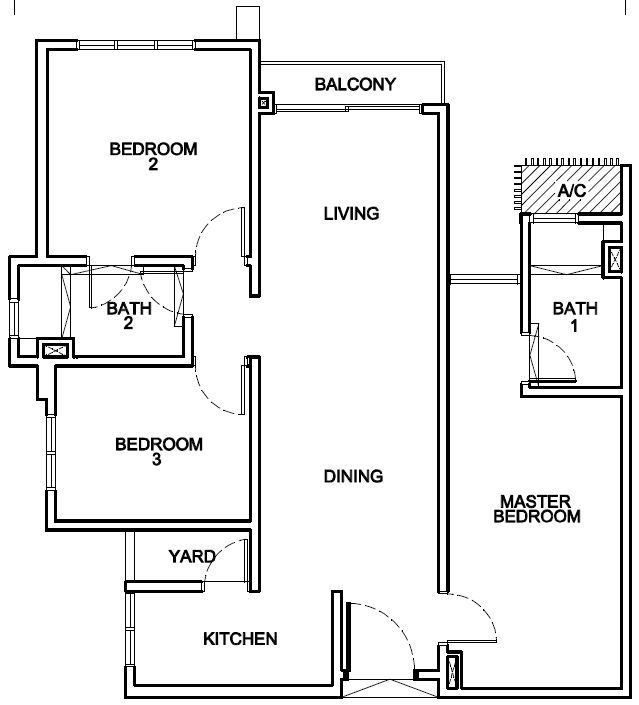

<ipython-input-15-730bb39d2196>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


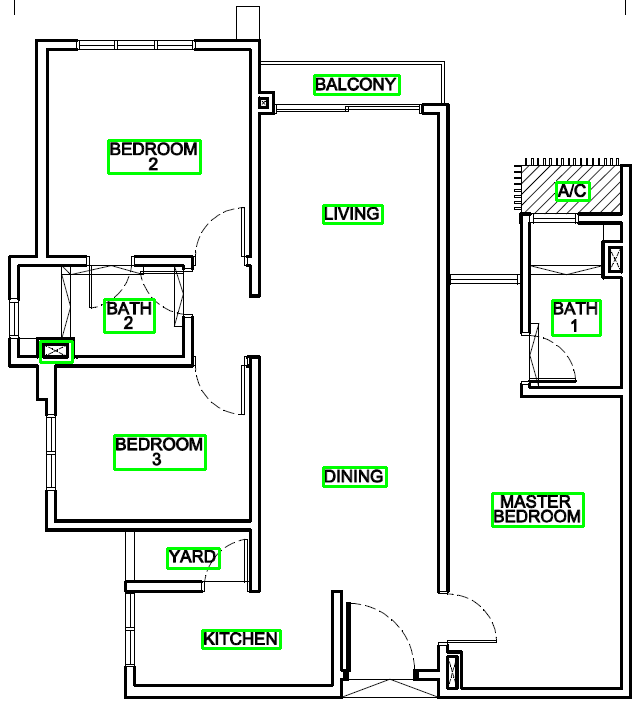

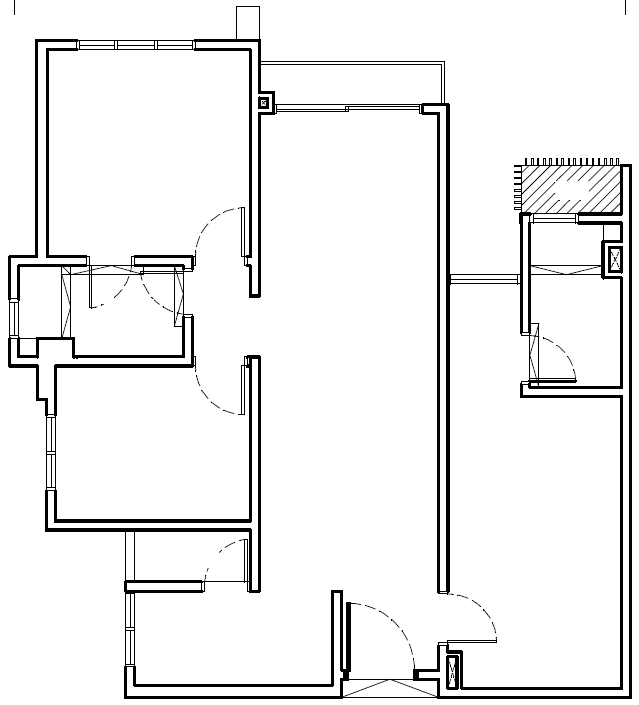

room labels: [('KITCHEN \x0c', (202, 630, 78, 18)), ('YARD \x0c', (167, 548, 52, 20)), ('MASTER BEDROOM \x0c', (492, 493, 91, 33)), ('DINING \x0c', (323, 467, 63, 19)), ('BEDROOM \x0c', (114, 435, 91, 34)), ('t) \x0c', (40, 341, 32, 21)), ('BATH 1 \x0c', (552, 300, 48, 35)), ('BATH 2 \x0c', (104, 299, 50, 33)), ('LIVING \x0c', (323, 205, 59, 18)), ('AIC \x0c', (556, 182, 33, 18)), ('BEDROOM \x0c', (108, 140, 92, 33)), ('BALCONY \x0c', (314, 75, 85, 19))]


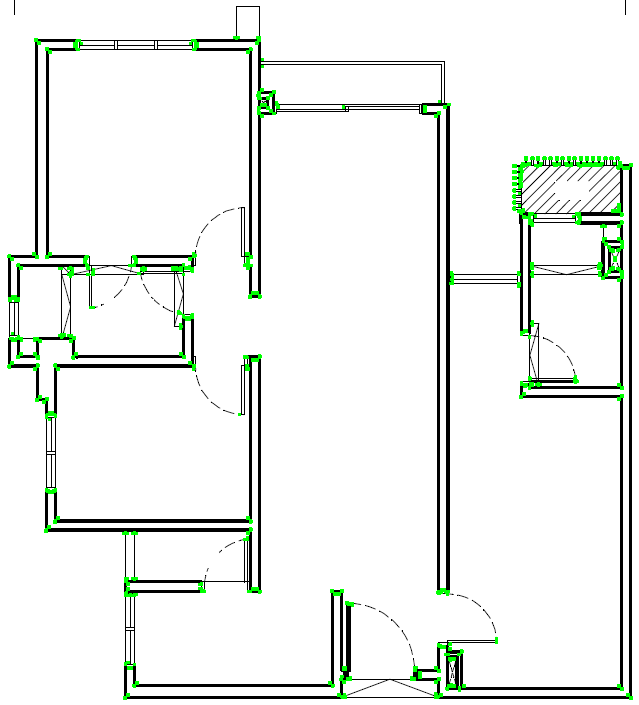

lines drawn


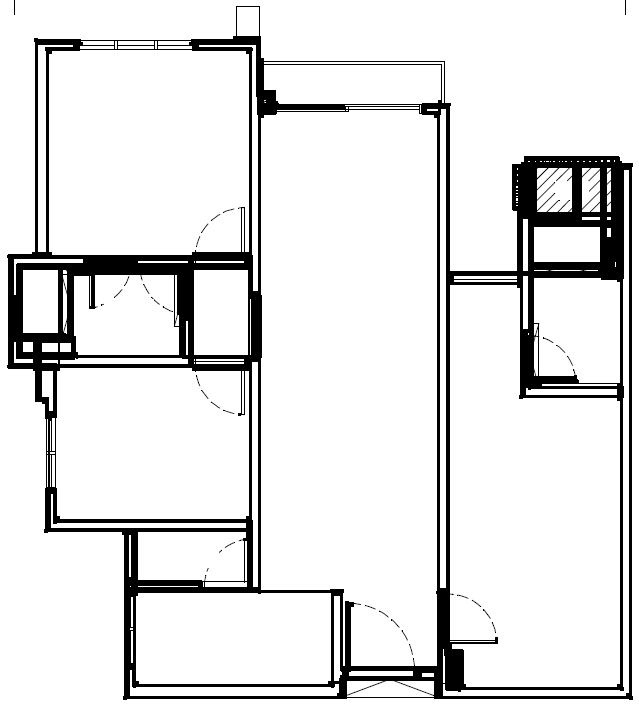

mor_img


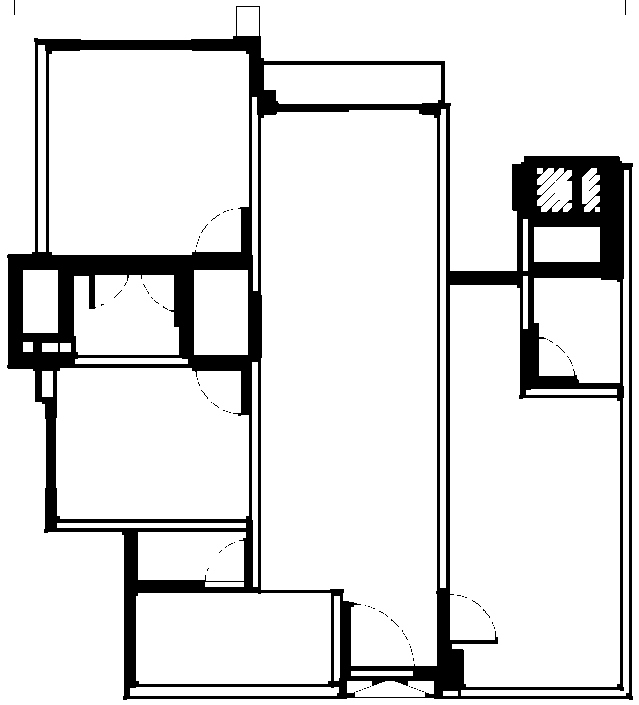

rooms detected


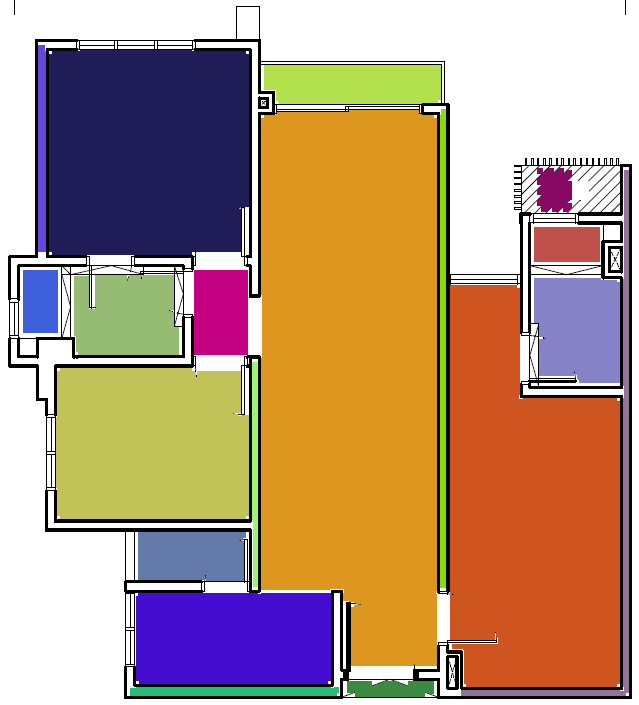


rooms coordinates: [(252, 362, 6, 225), (347, 681, 87, 16), (537, 168, 35, 44), (38, 45, 8, 207), (130, 687, 209, 9), (23, 270, 35, 63), (534, 227, 66, 35), (440, 109, 6, 479), (461, 170, 168, 526), (194, 270, 54, 85), (138, 532, 108, 49), (264, 65, 177, 39), (74, 275, 105, 80), (534, 278, 86, 105), (136, 593, 195, 91), (56, 368, 193, 151), (49, 50, 200, 205), (450, 285, 170, 402), (261, 110, 176, 556)]
final output


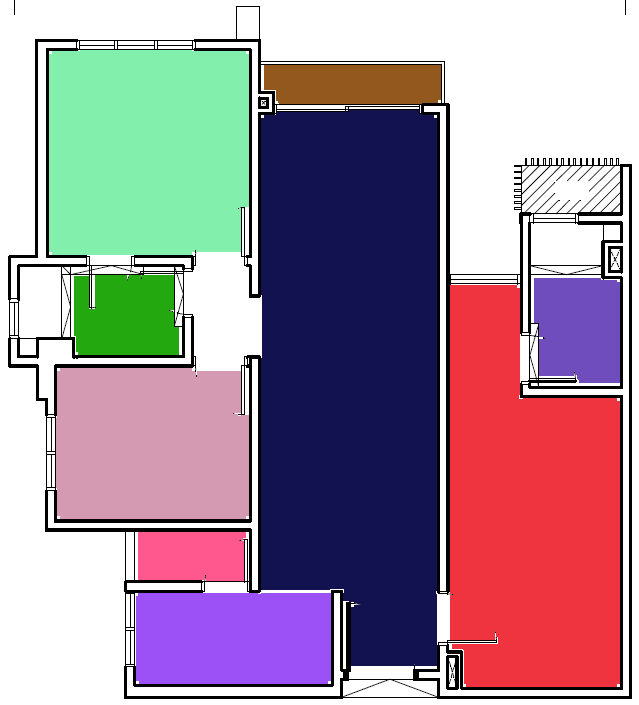


final output: [('YARD \x0c', (138, 532, 108, 49)), ('BALCONY \x0c', (264, 65, 177, 39)), ('BATH 2 \x0c', (74, 275, 105, 80)), ('BATH 1 \x0c', (534, 278, 86, 105)), ('KITCHEN \x0c', (136, 593, 195, 91)), ('BEDROOM \x0c', (56, 368, 193, 151)), ('BEDROOM \x0c', (49, 50, 200, 205)), ('MASTER BEDROOM \x0c', (450, 285, 170, 402)), ('DINING \x0c', (261, 110, 176, 556)), ('LIVING \x0c', (261, 110, 176, 556))]


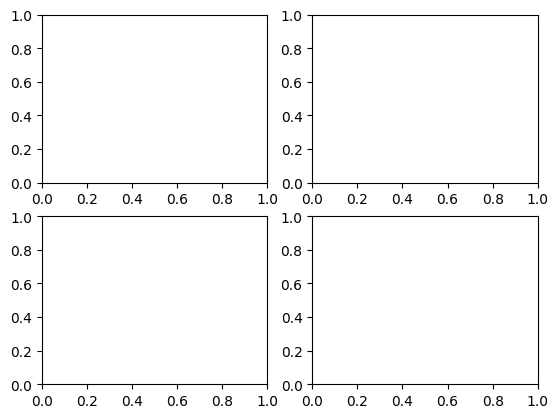

In [15]:
# the script is here

img = cv2.imread('/content/ARFP/Images/01.png') # change it to your desired image
cv2_imshow(img)

plt.figure()
plt.imshow(img)
room_labels, text_extracted_img = extract_room_labels(img)
cv2_imshow(text_extracted_img)
print("room labels: " + str(room_labels))

gaps_filled_img = fill_wall_gaps(text_extracted_img)
print("lines drawn")
cv2_imshow(gaps_filled_img)

room_coordinates, initial_contours, segmented_rooms_img = detect_rooms(gaps_filled_img, text_extracted_img)
print("rooms detected")
cv2_imshow( segmented_rooms_img)
print("\nrooms coordinates: " + str(room_coordinates))
print("final output")
final_list, final_segmented_rooms_img = match_room_and_label(room_labels, initial_contours, text_extracted_img)
cv2_imshow(final_segmented_rooms_img)
print("\nfinal output: " + str(final_list))

In [56]:
room_coordinates

[(252, 362, 6, 225),
 (347, 681, 87, 16),
 (537, 168, 35, 44),
 (38, 45, 8, 207),
 (130, 687, 209, 9),
 (23, 270, 35, 63),
 (534, 227, 66, 35),
 (440, 109, 6, 479),
 (461, 170, 168, 526),
 (194, 270, 54, 85),
 (138, 532, 108, 49),
 (264, 65, 177, 39),
 (74, 275, 105, 80),
 (534, 278, 86, 105),
 (136, 593, 195, 91),
 (56, 368, 193, 151),
 (49, 50, 200, 205),
 (450, 285, 170, 402),
 (261, 110, 176, 556)]